In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/cip/home/sch/schuboea/masterpraktikum_fibrosis_atlas/source')
from utils import plot_qc_joint

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


In [5]:
results_file = 'write/tsukui_ali.h5ad'  # the file that will store the analysis results

In [6]:
filenames = (glob.glob('/mnt/cip/home/sch/schuboea/tsukuidata/*.mtx'))
samplenames = []
for file in filenames:
    sample = '_'.join((file.split(sep="/")[-1]).split(sep="_")[0:-1])
    samplenames.append(sample)
print(samplenames)

['GSM3891618_UT1_GFPn', 'GSM3891617_UT2_GFPp', 'GSM3891614_Bleo1_GFPn', 'GSM3891612_Bleo1_GFPp', 'GSM3891613_Bleo2_GFPp', 'GSM3891615_Bleo2_GFPn', 'GSM3891616_UT1_GFPp', 'GSM3891619_UT2_GFPn']


In [7]:
#generate adata object for each sample matrix and store them in "adatas"-list
adatas = []
for sample in samplenames:
    adata = sc.read_10x_mtx(
    '/mnt/cip/home/sch/schuboea/tsukuidata/',  # the directory with the `.mtx` file
    prefix = sample + "_",                # sample name as prefix
    var_names='gene_symbols',             # use gene symbols for the variable names (variables-axis index)
    cache=True)                          # write a cache file for faster subsequent reading
    adata.var_names_make_unique()        # make sure genes with same name don´t cause trouble
    
    #add obs with condition, batch and gfp y/n info
    adata_copy = adata.copy()
    adata_copy.obs["batch"]=sample
    adata_copy.obs["condition"]=(sample.split(sep="_")[1])[:-1]
    adata_copy.obs["gfp"]=sample.split(sep="_")[2]
    adata = adata_copy
    adatas.append(adata)
print(adatas)

... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891618_UT1_GFPn_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891617_UT2_GFPp_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891614_Bleo1_GFPn_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891612_Bleo1_GFPp_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891613_Bleo2_GFPp_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891615_Bleo2_GFPn_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891616_UT1_GFPp_matrix.h5ad
... reading from cache file cache/mnt-cip-home-sch-schuboea-tsukuidata-GSM3891619_UT2_GFPn_matrix.h5ad
[AnnData object with n_obs × n_vars = 2411 × 27998
    obs: 'batch', 'condition', 'gfp'
    var: 'gene_ids', AnnData object with n_obs × n_vars = 3758 × 27998
    obs: 

In [8]:
#hier direkt concat
big_adata = adatas[0].concatenate(adatas[1:], join="outer") #index_unique=None?
print(big_adata)
#dann qc machen auf allen
#plots in seaborn direkt nebeneinander mit der gleichen achse (wie beim best practice buch -> histogramme)
#<3500 und mt <6

AnnData object with n_obs × n_vars = 26202 × 27998
    obs: 'batch', 'condition', 'gfp'
    var: 'gene_ids'


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [36]:
big_adata.var

,gene_ids
Xkr4,ENSMUSG00000051951
Gm1992,ENSMUSG00000089699
Gm37381,ENSMUSG00000102343
Rp1,ENSMUSG00000025900
Rp1-1,ENSMUSG00000109048
...,...
AC168977.1,ENSMUSG00000079808
PISD,ENSMUSG00000095041
DHRSX,ENSMUSG00000063897
Vmn2r122,ENSMUSG00000096730


filtered out 9 cells that have less than 250 genes expressed
filtered out 9246 genes that are detected in less than 3 cells


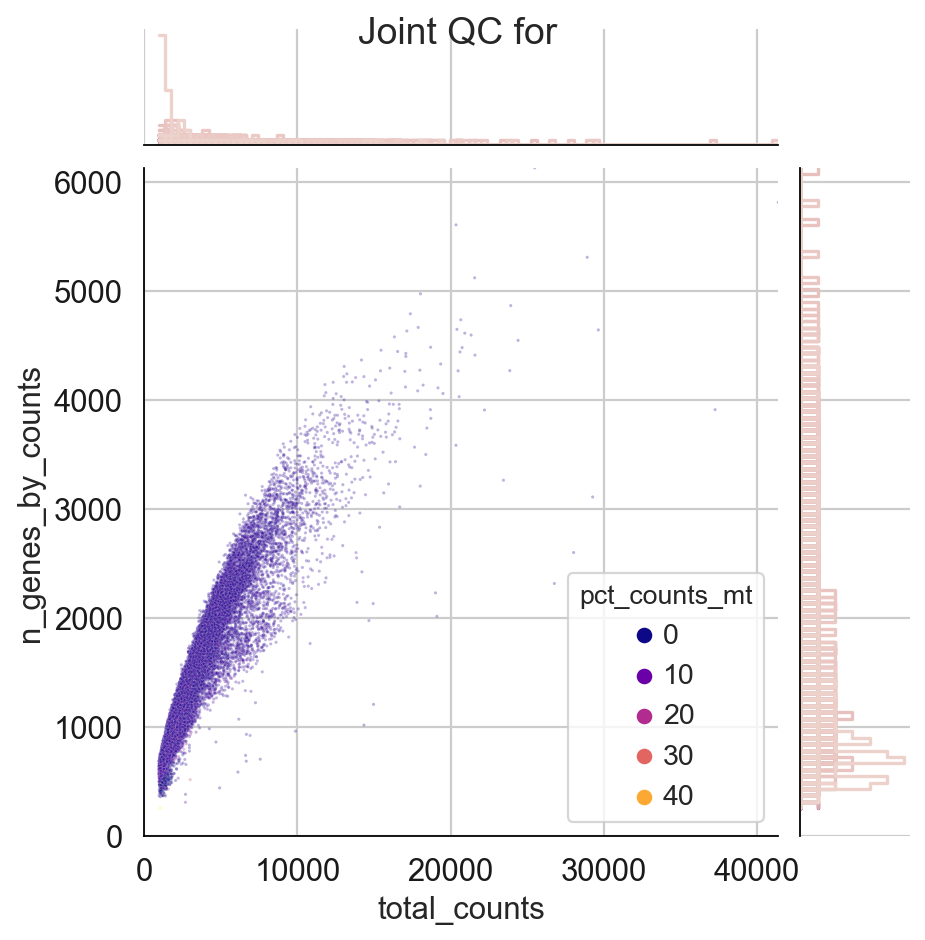

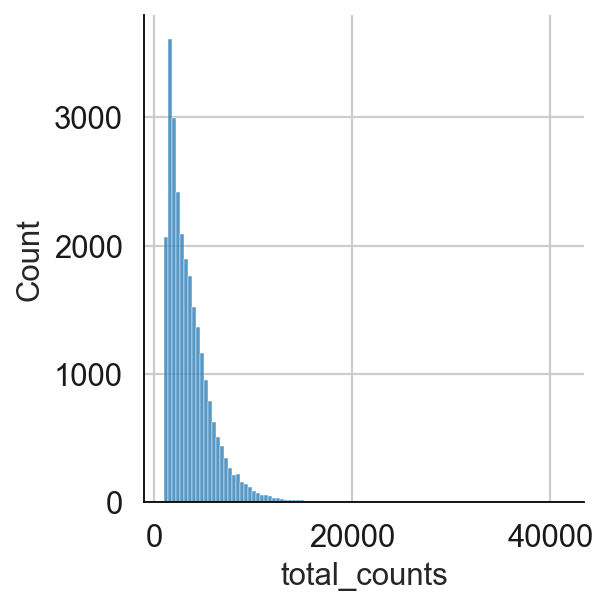

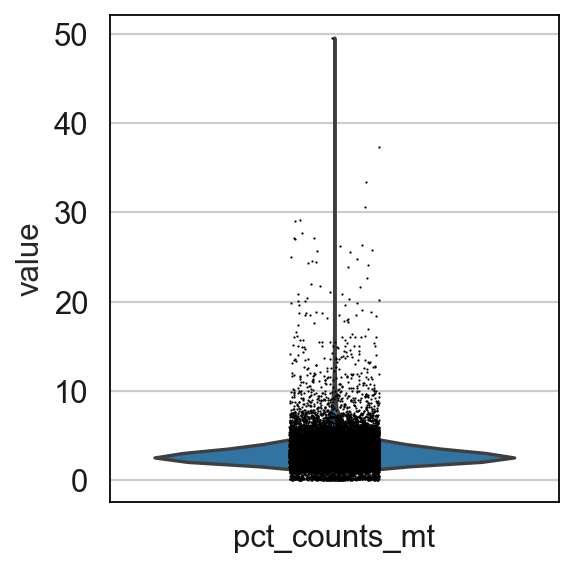

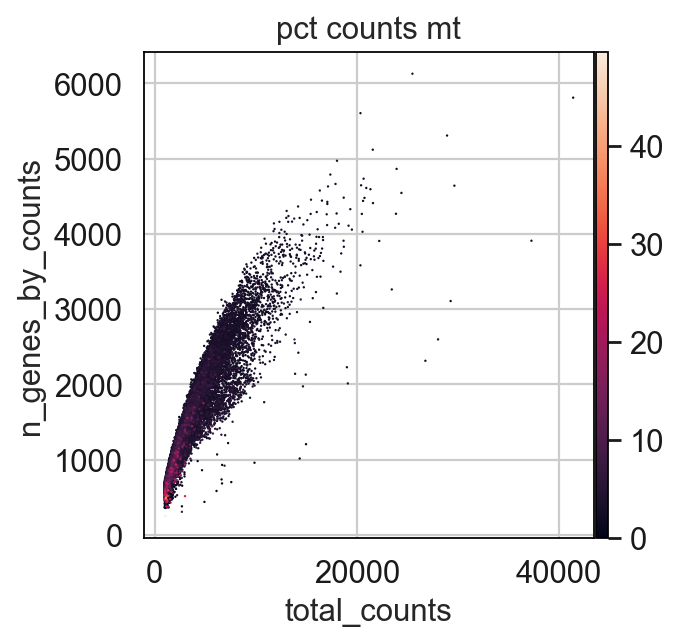

In [9]:
sc.pp.filter_cells(big_adata, min_genes=250)  #filter out cells with less than 250 genes (from publication), usually it´s 200?
sc.pp.filter_genes(big_adata, min_cells=3) #filter out genes that are seen in less than 3 cells

# mitochondrial genes
big_adata.var["mt"] = big_adata.var_names.str.startswith("mt-")
#Calculate QC metrics and plot
sc.pp.calculate_qc_metrics(big_adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=True)

#using Michi´s plotting function (key error for "total counts")
plt = plot_qc_joint(
        big_adata,
        x='total_counts',  # generated by sc.pp.calculate_qc_metrics
        y='n_genes_by_counts',  # generated by sc.pp.calculate_qc_metrics
        hue='pct_counts_mt',  # generated by sc.pp.calculate_qc_metrics
        palette='plasma',
        marginal_hue='pct_counts_mt',
        title=('Joint QC for '),
    )


#the way I did it in the beginning
'''sc.pl.violin(big_adata, [ 'total_counts', 'pct_counts_mt', 'n_genes_by_counts'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(big_adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(big_adata, x='total_counts', y='pct_counts_mt')'''

#literally the only thing that works
p1 = sns.displot(big_adata.obs["total_counts"], bins=100, kde=False, height=4, aspect=1)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(big_adata, "pct_counts_mt")
p3 = sc.pl.scatter(big_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


big_adata = big_adata[big_adata.obs.n_genes_by_counts < 3500, :]
big_adata = big_adata[big_adata.obs.pct_counts_mt < 6, :]         #Hier percent gegen [5] für standard oder [10] von pub tauschen (oder MAD nehmen wie in best practices)


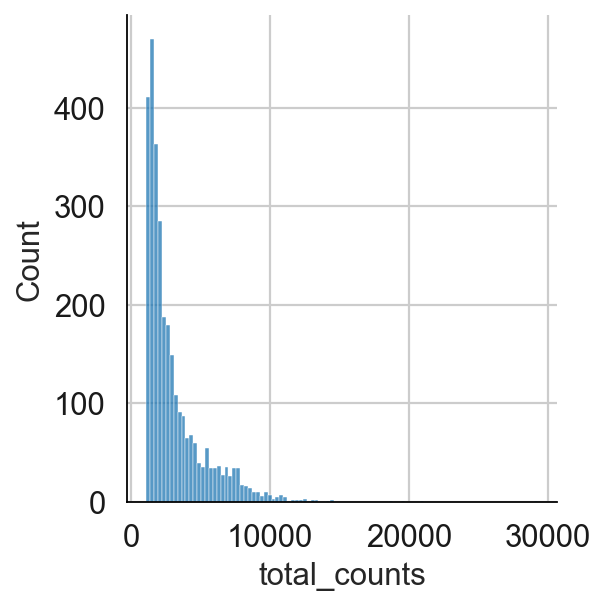

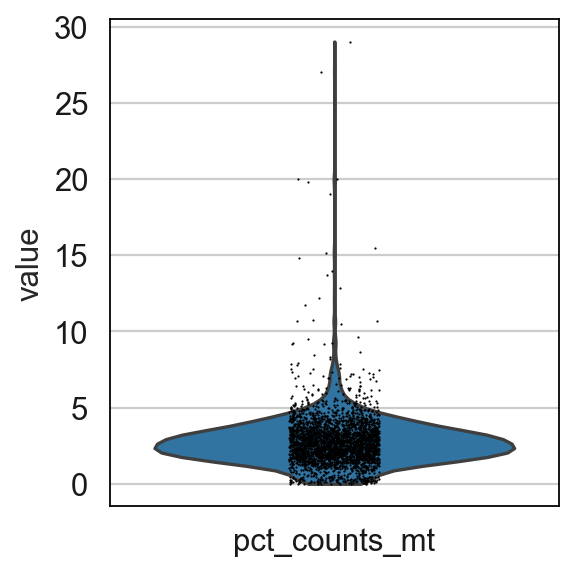

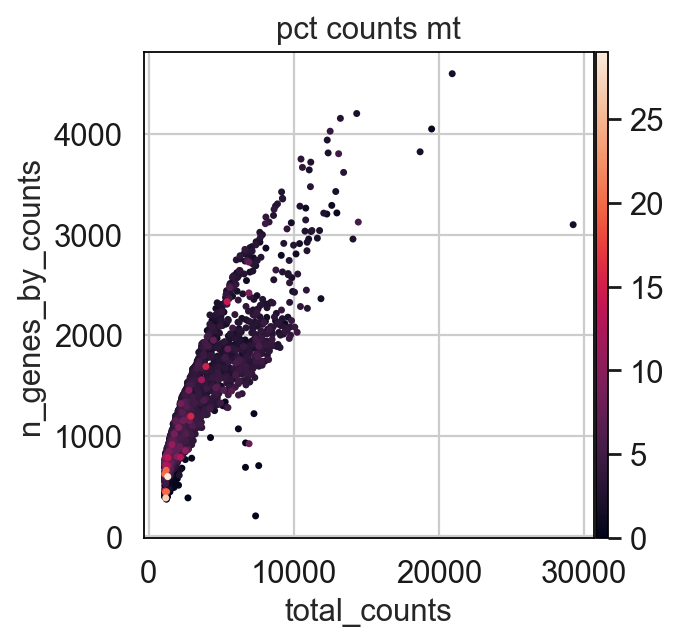

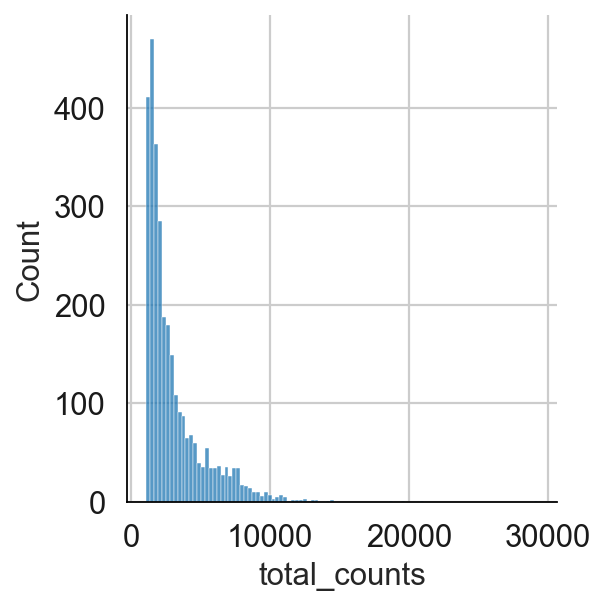

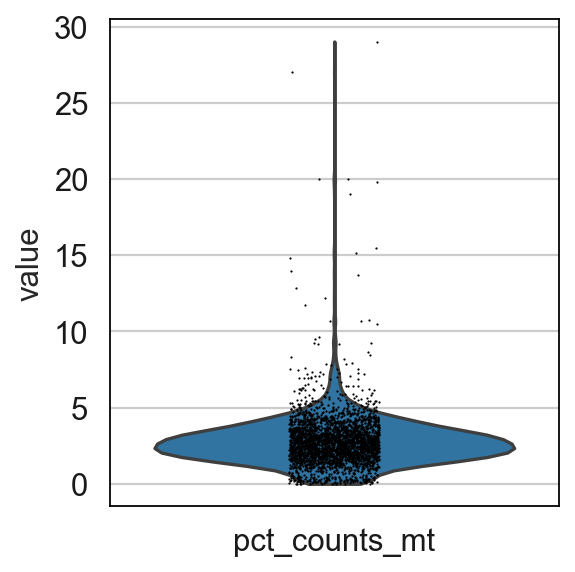

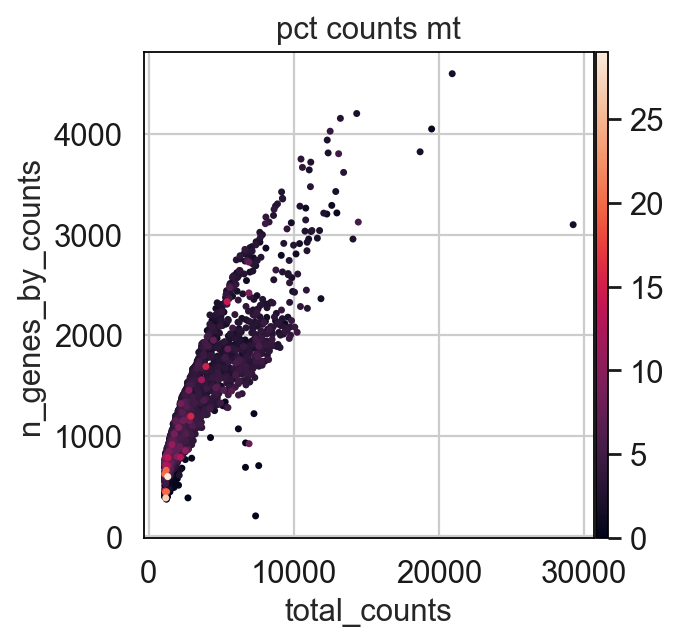

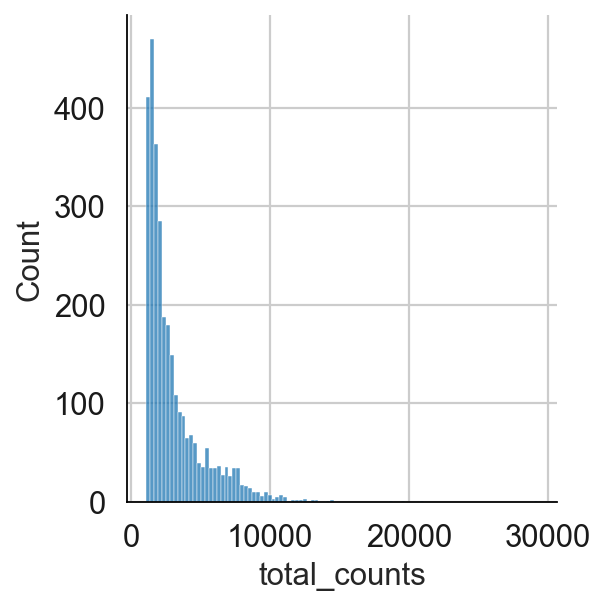

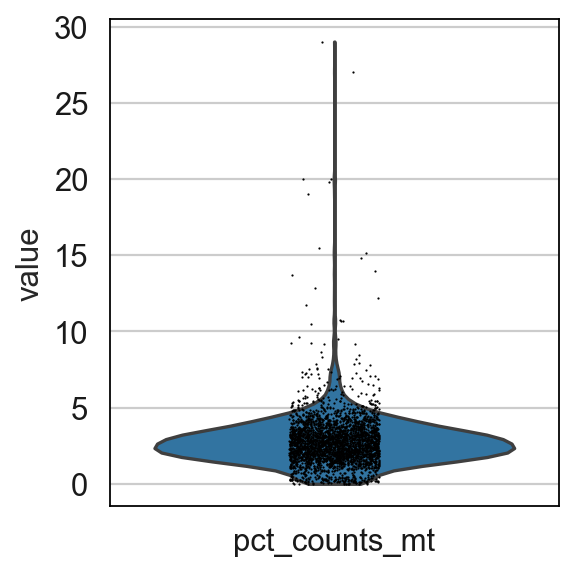

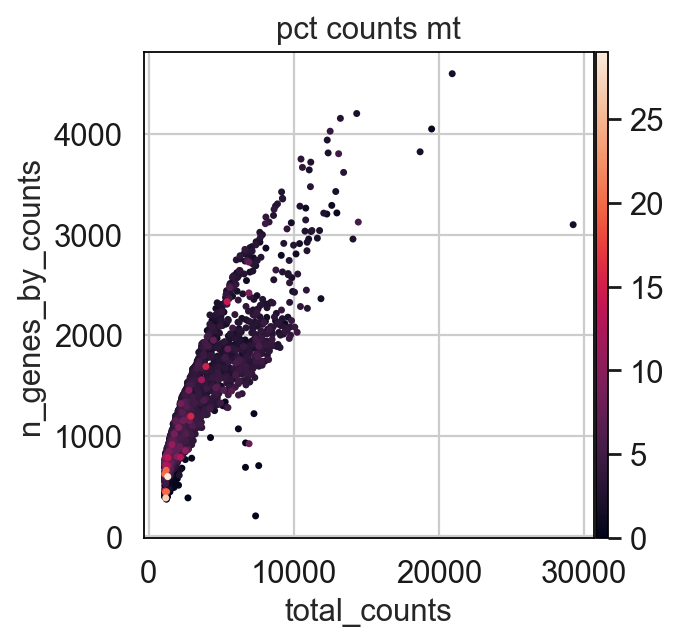

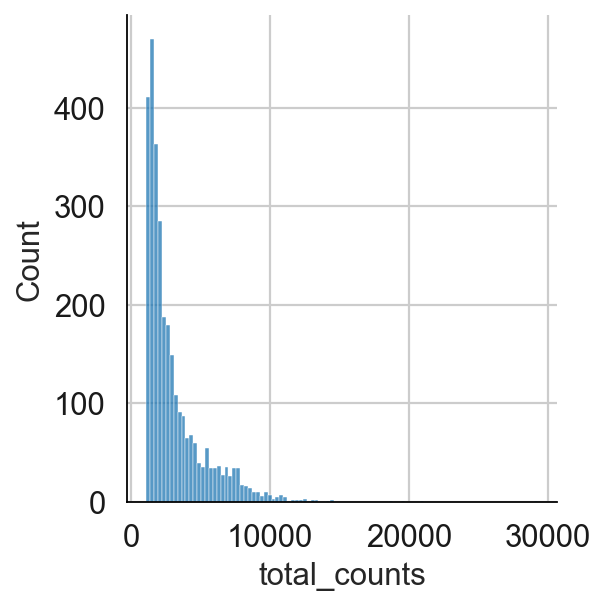

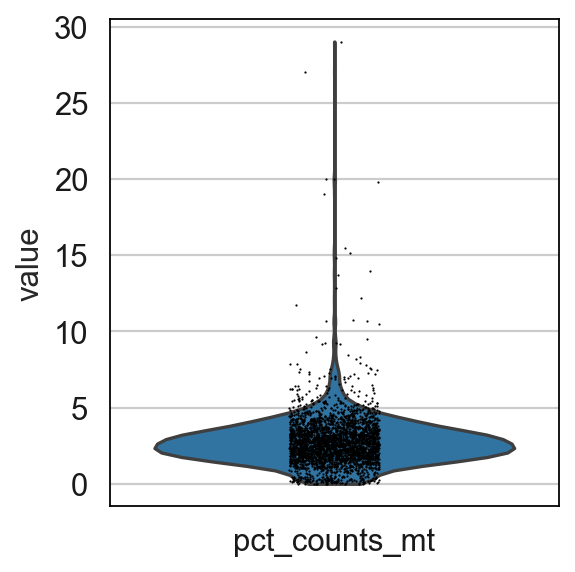

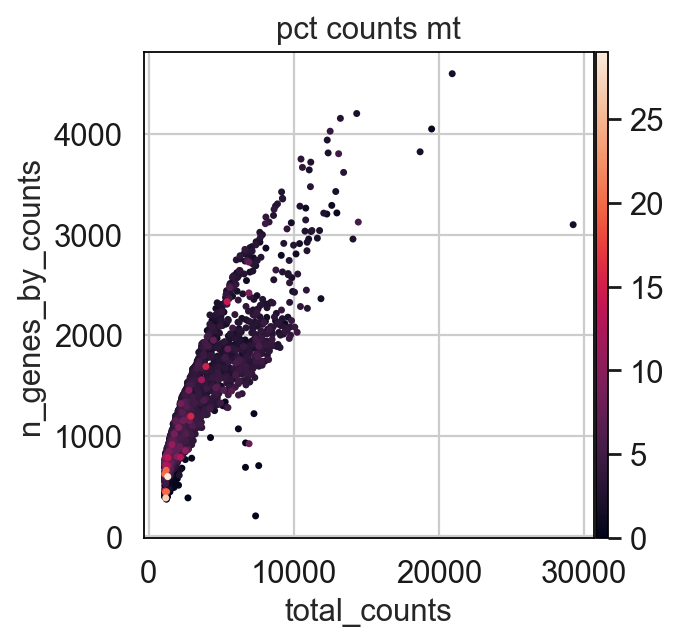

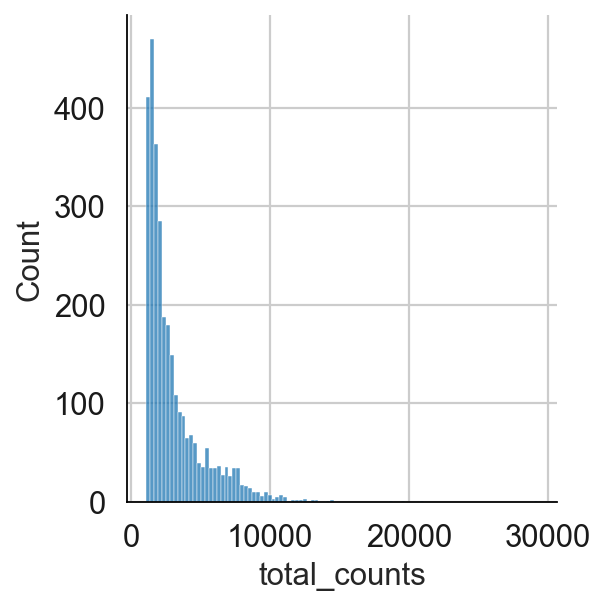

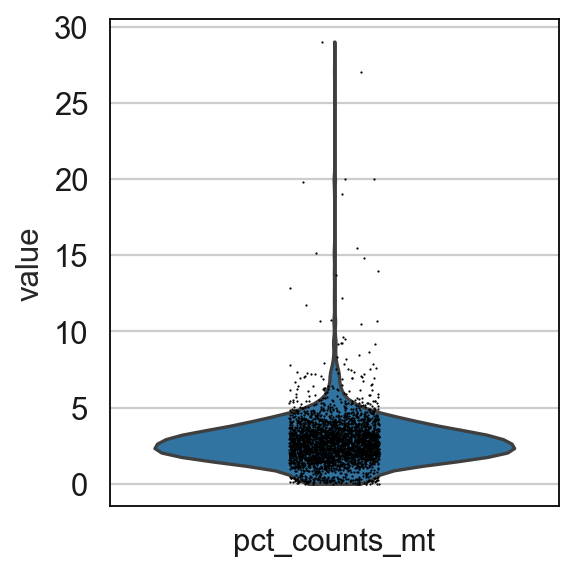

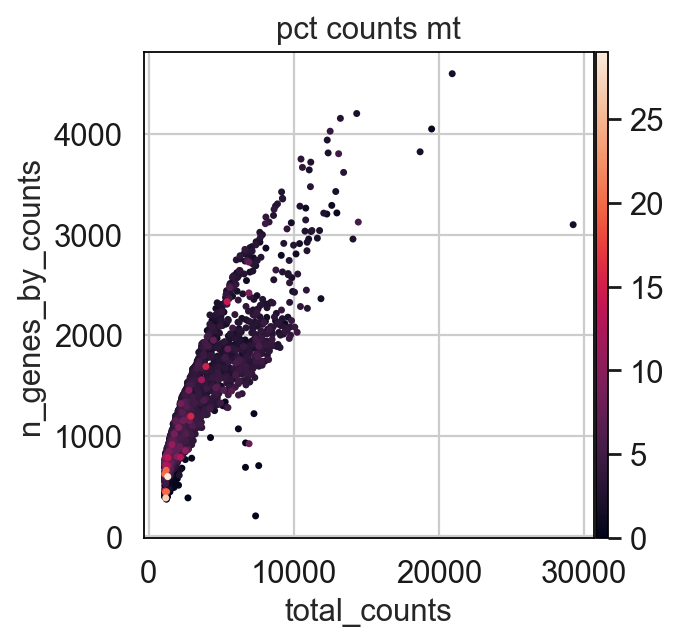

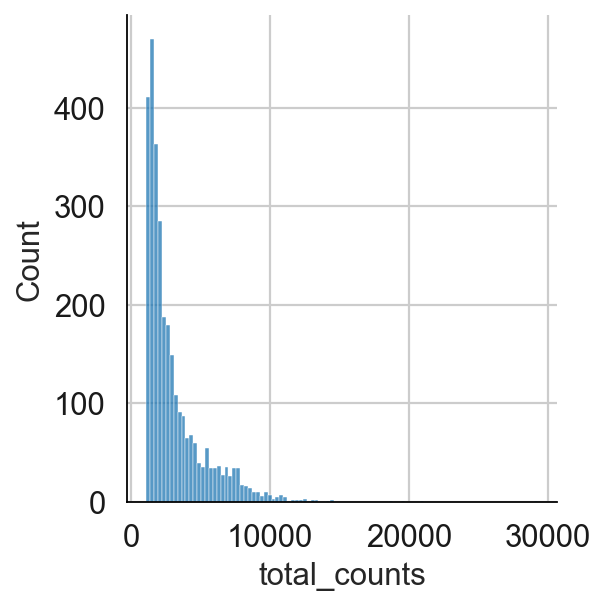

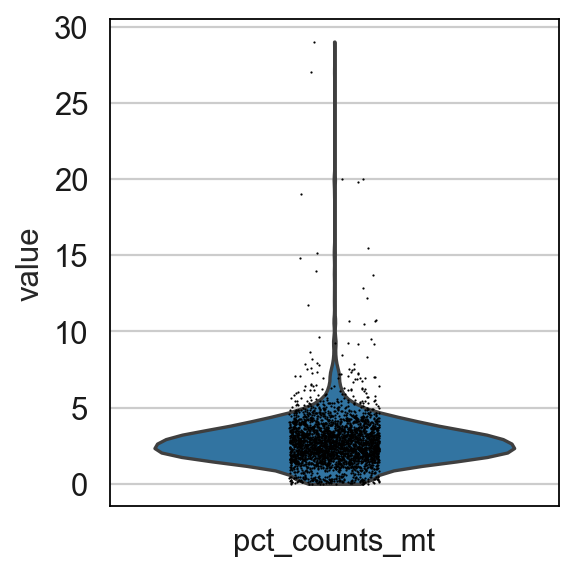

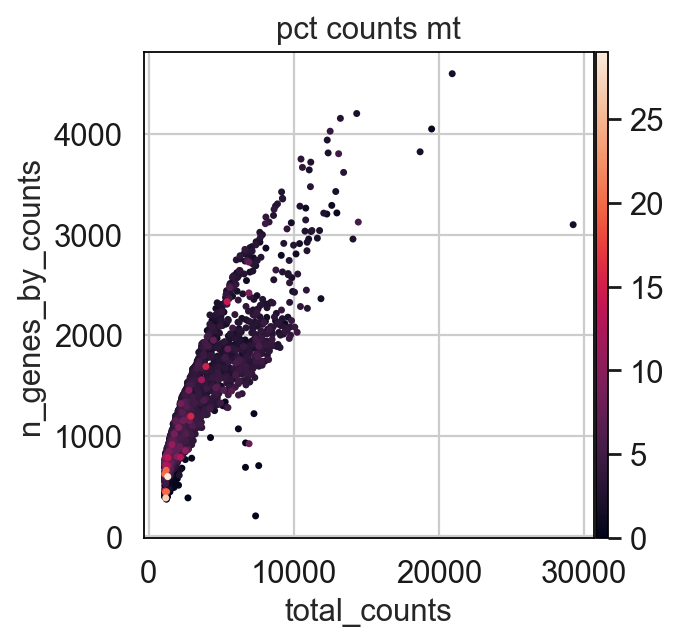

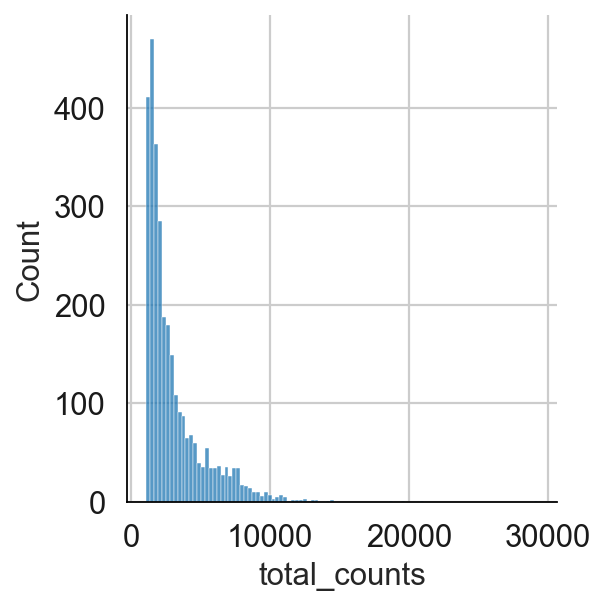

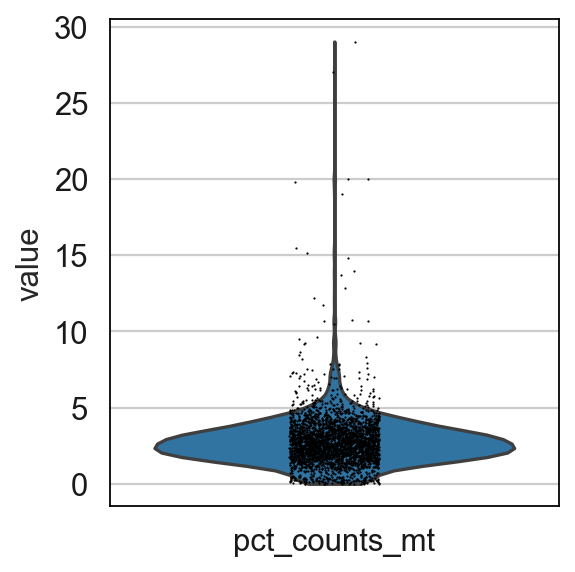

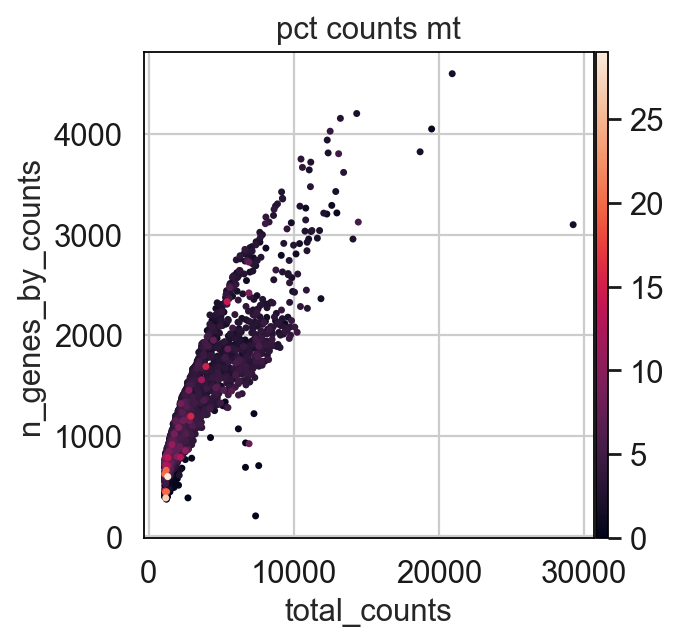

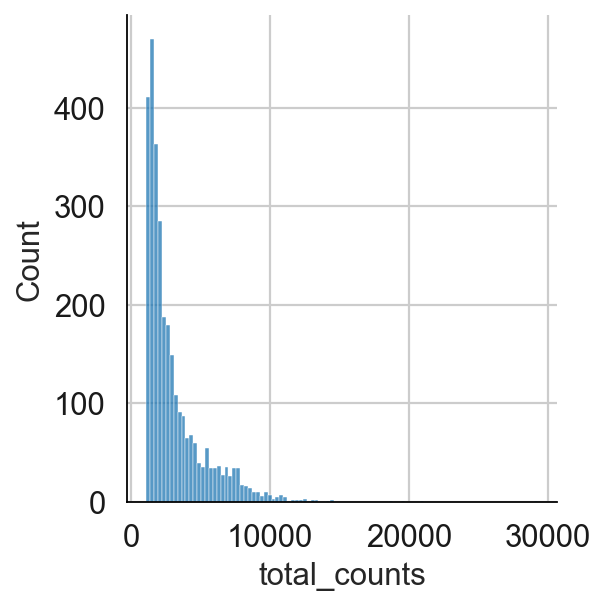

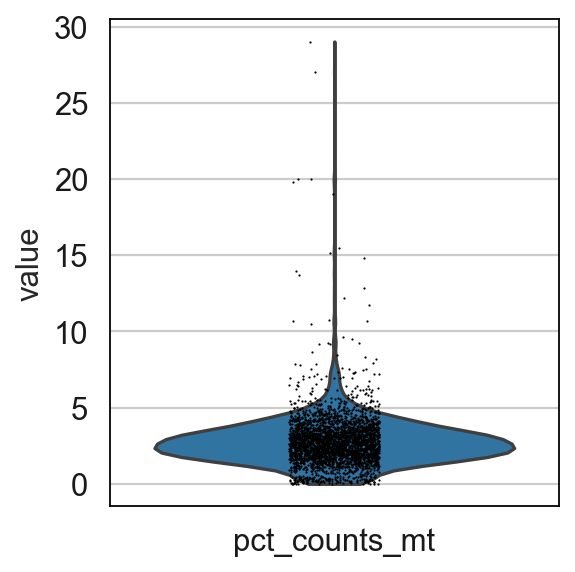

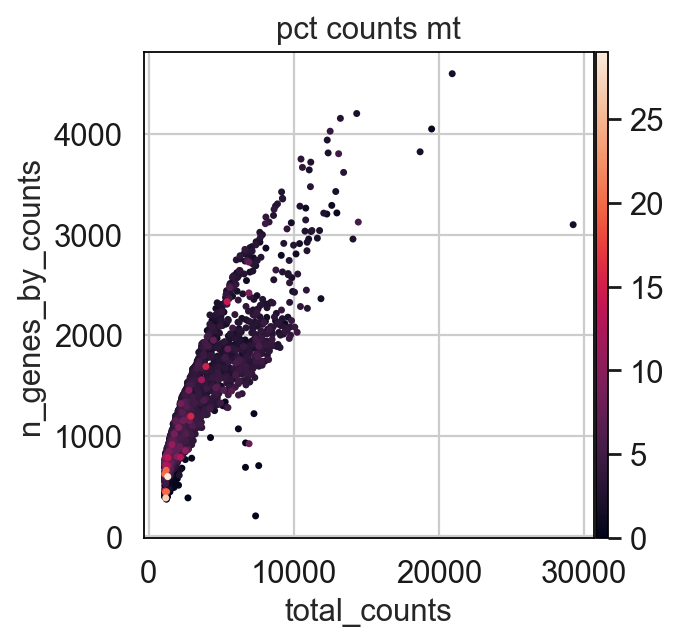

In [24]:
'''counter=0
for sample in samplenames:    
    #sc.pp.filter_cells(adatas[counter], min_genes=250)  #filter out cells with less than 250 genes (from publication), usually it´s 200?
    sc.pp.filter_genes(adatas[counter], min_cells=3) #filter out genes that are seen in less than 3 cells
    
    # mitochondrial genes
    adatas[counter].var["mt"] = adatas[counter].var_names.str.startswith("mt-")
    #Calculate QC metrics and plot
    sc.pp.calculate_qc_metrics(adatas[counter], qc_vars=["mt"], inplace=True, percent_top=None, log1p=True)
    
    #using Michi´s plotting function (key error for "total counts")
    plot_qc_joint(
            adatas[counter],
            x='total_counts',  # generated by sc.pp.calculate_qc_metrics
            y='n_genes_by_counts',  # generated by sc.pp.calculate_qc_metrics
            hue='pct_counts_mt',  # generated by sc.pp.calculate_qc_metrics
            palette='plasma',
            marginal_hue='pct_counts_mt',
            title=('Joint QC for '+sample),
        )
    
    #the way I did it in the beginning
    sc.pl.violin(adatas[counter], [ 'total_counts', 'pct_counts_mt', 'n_genes_by_counts'],
                 jitter=0.4, multi_panel=True)
    sc.pl.scatter(adatas[counter], x='total_counts', y='n_genes_by_counts')
    sc.pl.scatter(adatas[counter], x='total_counts', y='pct_counts_mt')
    
    #literally the only thing that works
    p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False, height=4, aspect=1)
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(adata, "pct_counts_mt")
    p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    
    
    adatas[counter] = adatas[counter][adatas[counter].obs.n_genes_by_counts < 3500, :]
    adatas[counter] = adatas[counter][adatas[counter].obs.pct_counts_mt < 6, :]         #Hier percent gegen [5] für standard oder [10] von pub tauschen (oder MAD nehmen wie in best practices)
    
    counter+=1
    '''

In [13]:
#doublet detection with scrublet
sc.external.pp.scrublet(big_adata, batch_key = "batch")

Running Scrublet
filtered out 4100 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 35.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.3%
filtered out 3556 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 6.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%
filtered out 4563 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 23.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.0%
filtered out 2815 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.28
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 32.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.2%
filtered out 2730 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.27
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 33.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.5%
filtered out 4249 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 12.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.0%
filtered out 3208 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 8.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.9%
filtered out 3822 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/home/sch/schuboea/miniforge3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.23
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.1%
    Scrublet finished (0:00:14)


In [15]:
#Total-count normalize (library-size correct) the data matrix, each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(big_adata, target_sum=None)
#Logarithmize the data matrix
sc.pp.log1p(big_adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


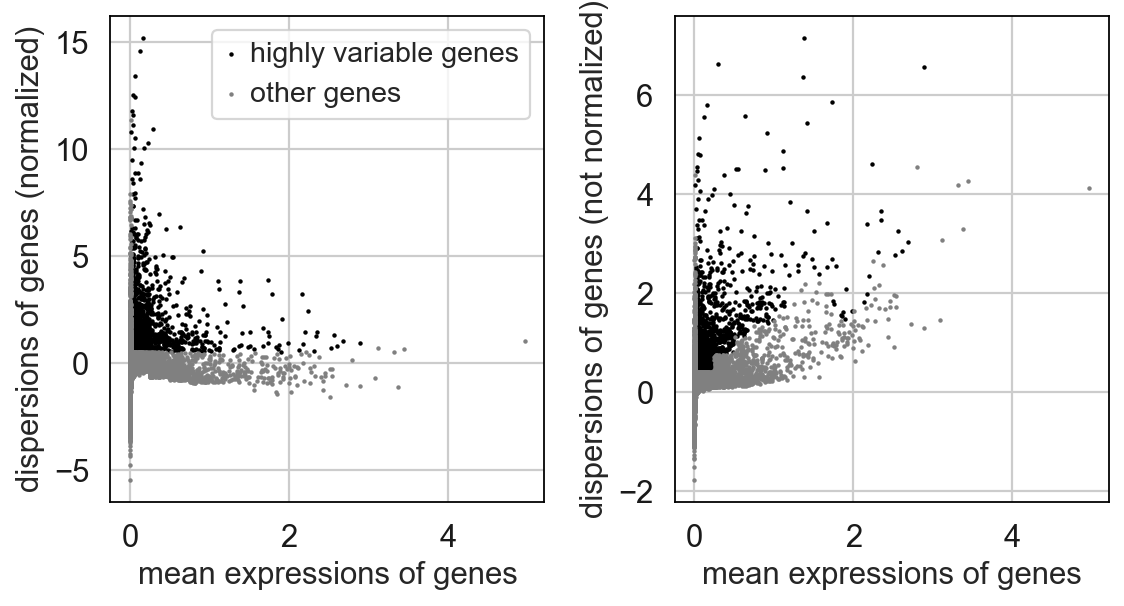

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:04:21)


In [22]:
#feature selection by selecting highly variable genes
sc.pp.highly_variable_genes(big_adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored
sc.pl.highly_variable_genes(big_adata)

#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = big_adata

#actually do the filtering
adata = big_adata[:, big_adata.var.highly_variable]
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(big_adata, ['total_counts', 'pct_counts_mt'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(big_adata, max_value=10)


In [25]:
big_adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
Xkr4,ENSMUSG00000051951,28,False,28,0.001069,0.001068,99.893101,28.0,3.367296,False,0.000945,0.059701,-0.455856,2.304351e-12,0.020855
Rp1,ENSMUSG00000025900,29,False,29,0.001336,0.001335,99.889283,35.0,3.583519,False,0.000510,-0.105902,-0.907633,2.823660e-12,0.014884
Sox17,ENSMUSG00000025902,3084,False,3084,0.247585,0.221210,88.225862,6485.0,8.777401,True,0.237440,1.232458,2.743522,-2.263162e-11,0.377831
Mrpl15,ENSMUSG00000033845,4744,False,4744,0.208605,0.189467,81.888291,5464.0,8.606119,False,0.163054,0.140617,-0.235108,-6.063834e-12,0.272627
Lypla1,ENSMUSG00000025903,4104,False,4104,0.175963,0.162087,84.331692,4609.0,8.435983,False,0.145956,0.196269,-0.083286,-3.451145e-11,0.261091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.2,ENSMUSG00000094915,15,False,15,0.000573,0.000573,99.942733,15.0,2.772589,False,0.000641,0.409176,0.497541,6.979399e-12,0.018442
AC168977.1,ENSMUSG00000079808,73,False,73,0.003283,0.003278,99.721300,86.0,4.465908,False,0.002254,0.174066,-0.143859,-2.115294e-12,0.032801
PISD,ENSMUSG00000095041,5207,False,5207,0.253388,0.225851,80.120643,6637.0,8.800566,True,0.211720,0.446989,0.600699,1.092987e-11,0.323715
DHRSX,ENSMUSG00000063897,2714,False,2714,0.113160,0.107203,89.638453,2964.0,7.994632,False,0.090343,0.156907,-0.190668,4.716315e-12,0.204609


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


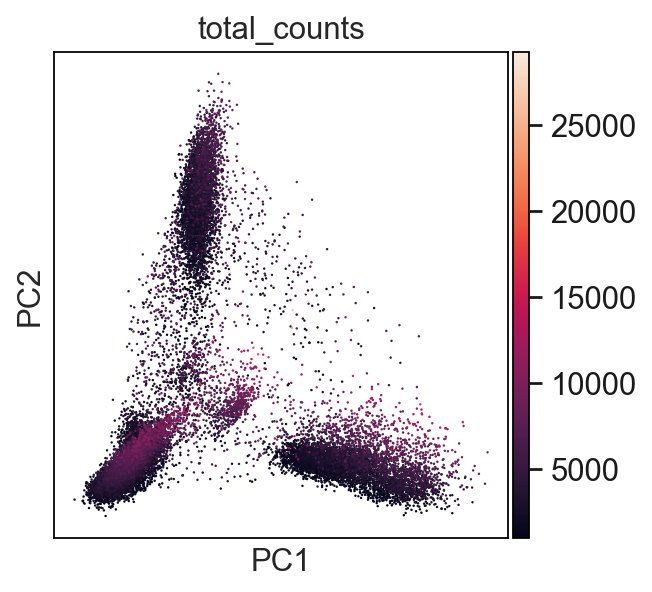

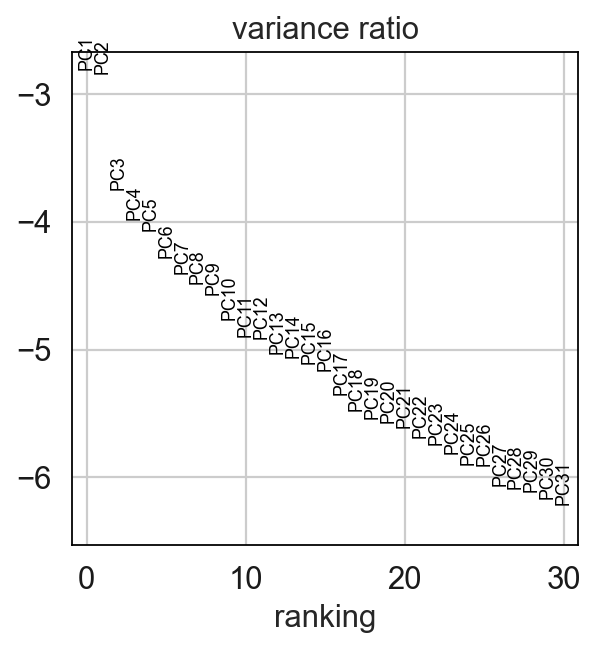

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:54)


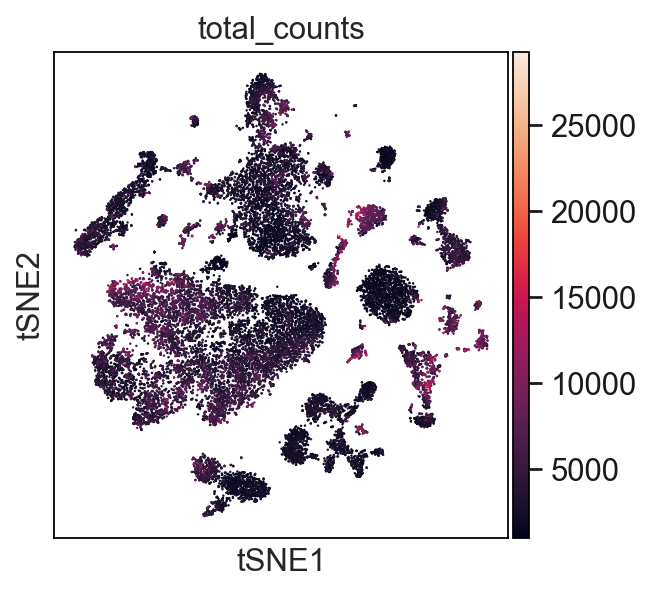

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


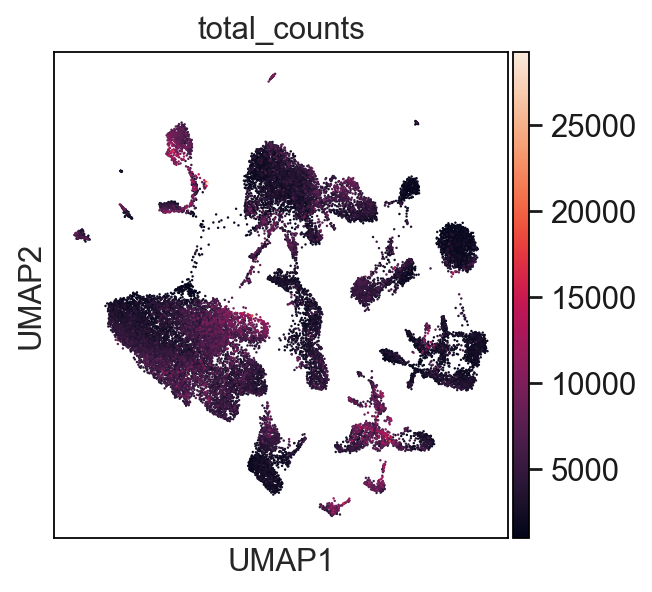

KeyError: 'Could not find key scDblFinder_score in .var_names or .obs.columns.'

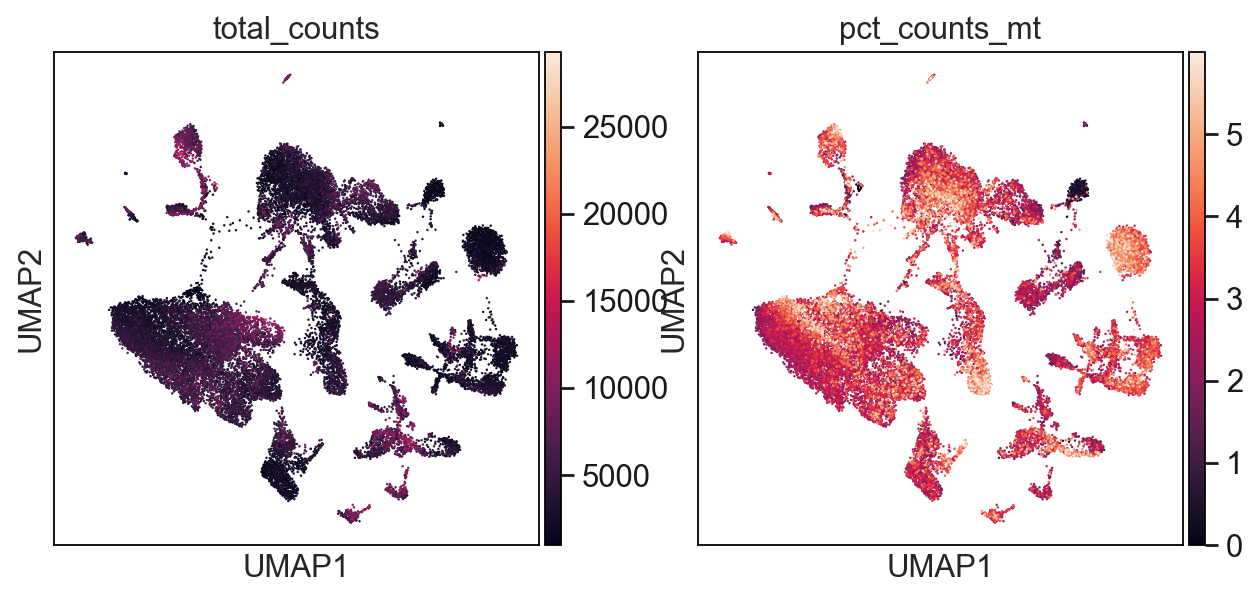

In [27]:
#PCA:
sc.pp.pca(big_adata, svd_solver="arpack", use_highly_variable=True)
#from scanpy tut: sc.tl.pca(big_adata, svd_solver='arpack')
sc.pl.pca(big_adata, color="total_counts")
sc.pl.pca_variance_ratio(big_adata, log=True)
sc.tl.tsne(big_adata, use_rep="X_pca")
sc.pl.tsne(big_adata, color="total_counts")
sc.pp.neighbors(big_adata)
sc.tl.umap(big_adata)
sc.pl.umap(big_adata, color="total_counts")

sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

big_adata.write("tsukui_dimensionality_reduced.h5ad")
#big_adata

In [ ]:
#preprocessing for each adata object in the list
for adata in adatas:
    sc.pp.filter_cells(adata, min_genes=250)  #filter out genes with less than 250 genes (from publication)
    '''sc.pp.filter_cells(ts, min_genes=300)
    sc.pp.filter_cells(ts, max_genes=4600)     #daniels cut offs
    sc.pp.filter_cells(ts, max_counts=20000)'''
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("rps", "rpl"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^hb[^(p)]"))
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[10], log1p=True)
    adata